In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

**Пути к директориям и папкам**

In [92]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

# Загрузка данных

**Описание датасета**

В датасете представлены данные о пассажирах Титаника, их возраст, пол и другие характеристики

**Задача:**

Исследование разных методов классификации:

* Логистическая регрессия  
* Метод опорных векторов (SVG)  
* Алгоритм k-ближайщих соседей (KNN)  
* Деревья решений (Decision Trees)
* Случайный лес (Random Forest)

С применением метрики качества Accuracy

# Предварительный анализ
**Для начала посмотрим на данные**

In [3]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, index_col='PassengerId')
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [4]:
test_df = pd.read_csv(TEST_DATASET_PATH, index_col='PassengerId')
test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S


In [5]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,714.00,891.00,891.00,891.00
mean,0.38,2.31,29.70,0.52,0.38,32.20
std,0.49,0.84,14.53,1.10,0.81,49.69
min,0.00,1.00,0.42,0.00,0.00,0.00
25%,0.00,2.00,20.12,0.00,0.00,7.91
50%,0.00,3.00,28.00,0.00,0.00,14.45
75%,1.00,3.00,38.00,1.00,0.00,31.00
max,1.00,3.00,80.00,8.00,6.00,512.33


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [7]:
train_df.nunique()

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64

In [8]:
train_df.shape, test_df.shape

((891, 11), (418, 10))

**Выводы после первого просмотра**

Целевым значением будет значение "Survived" (Выжил)

* Всего пассажиров 891  
* Много пропущенных значений в "Age" (Возраст пассажира) (есть 714 из 891, % потерь 19.86) **заполним пропущенные значения средним**  
* Практически отсутсвуют значения в "Cabin" (Номер каюты) (есть 204 из 891, % потерь 77.10) **удалим**  
* "Pclass" и "Embarked" имеют всего по 3 уникальных значения, поэтому **переведем их в Dummy-переменные**  
* "Name" (имя пассажира) известное имя или популярность пассажира могла повлиять на его выживаемость, но в формате данного анализа рассмотрение такого влияния не предоставляется возможным, поэтому **столбец придётся удалить**, как и "Ticket" (номер билета) и "PassengerID" (айди пассажира), значения которых скорее просто номинально-отчетные


# Приступим к очистке данных

Удалим "Name", "Ticket" и "Cabin" из Train и Test

In [9]:
train_df.drop(columns=["Name", "Ticket", "Cabin"], axis=1, inplace=True, errors='ignore')
test_df.drop(columns=["Name", "Ticket", "Cabin"], axis=1, inplace=True, errors='ignore')

Проверим результат

In [10]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.00,1,0,7.25,S
2,1,1,female,38.00,1,0,71.28,C
3,1,3,female,26.00,0,0,7.92,S
4,1,1,female,35.00,1,0,53.10,S
5,0,3,male,35.00,0,0,8.05,S


**Заполним пропущенные значения**

**Age**

Заполним по медиане

In [11]:
age_mean = train_df['Age'].mean()
print(age_mean)
train_df['Age'].fillna(age_mean, inplace=True)

29.69911764705882


Проверим результат

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.6+ KB


**Embarked**

Так как это категориальный признак, сначала рассмотрим какие значения присутсвуют

In [13]:
train_df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Заполним по наиболее встречающемуся значению - "S"

In [14]:
train_df["Embarked"].fillna("S", inplace=True)

Проверим результат

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.6+ KB


**Пропущенных значений больше нет**

**Рассмотрим параметр "Sex" (пол пассажира)**

In [16]:
train_df["Sex"].unique()

array(['male', 'female'], dtype=object)

Как и ожидалось всего два значения, поэтому заменим их на числовые значения 1 и 0

In [17]:
sex_map = {
    "female": 1, 
    "male": 0
}

train_df["Sex"] = train_df["Sex"].map(sex_map)

Проверим результат

In [18]:
train_df["Sex"].unique()

array([0, 1])

**Рассмотрим категориальные признаки**

**Embarked**

Превратим его в Dummy-переменные

In [19]:
train_df["Embarked"].unique()

array(['S', 'C', 'Q'], dtype=object)

In [20]:
train_df = pd.get_dummies(train_df)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0,3,0,22.00,1,0,7.25,0,0,1
2,1,1,1,38.00,1,0,71.28,1,0,0
3,1,3,1,26.00,0,0,7.92,0,0,1
4,1,1,1,35.00,1,0,53.10,0,0,1
5,0,3,0,35.00,0,0,8.05,0,0,1


**Pclass**

Превратим его в Dummy-переменные (необходимо дописать уточнение)

In [21]:
train_df["Pclass"] = train_df["Pclass"].astype("category")
train_df = pd.get_dummies(train_df)
train_df.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,
1,0,0,22.00,1,0,7.25,0,0,1,0,0,1
2,1,1,38.00,1,0,71.28,1,0,0,1,0,0
3,1,1,26.00,0,0,7.92,0,0,1,0,0,1
4,1,1,35.00,1,0,53.10,0,0,1,1,0,0
5,0,0,35.00,0,0,8.05,0,0,1,0,0,1


**Разбиение датасета на Тренировочный (Train), Валидационный (Valid) и Тестовый (Test)**

Вынесем столбец с целевой переменной "Survived" в отдельную переменную "Y", а всё остальное в "X"

In [22]:
target = "Survived"
y = train_df[target]
X = train_df.drop(target, axis = 1)

In [23]:
X.head()

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,
1,0,22.00,1,0,7.25,0,0,1,0,0,1
2,1,38.00,1,0,71.28,1,0,0,1,0,0
3,1,26.00,0,0,7.92,0,0,1,0,0,1
4,1,35.00,1,0,53.10,0,0,1,1,0,0
5,0,35.00,0,0,8.05,0,0,1,0,0,1


In [24]:
y.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

**Разобъём данные из train.csv:**
* тренировочный (признаки в X_train, целевая в y_train)
* валидационный (признаки в X_valid, целевая в y_valid)

На тренировочном (X_train) будет строить модель, на валидационном (X_valid) проверять качество модели, а финальный тест проводить на тестовом (test_df)

**Разобъём данные на train и valid:**

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 299 to 103
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sex         668 non-null    int64  
 1   Age         668 non-null    float64
 2   SibSp       668 non-null    int64  
 3   Parch       668 non-null    int64  
 4   Fare        668 non-null    float64
 5   Embarked_C  668 non-null    uint8  
 6   Embarked_Q  668 non-null    uint8  
 7   Embarked_S  668 non-null    uint8  
 8   Pclass_1    668 non-null    uint8  
 9   Pclass_2    668 non-null    uint8  
 10  Pclass_3    668 non-null    uint8  
dtypes: float64(2), int64(3), uint8(6)
memory usage: 35.2 KB


In [27]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223 entries, 710 to 425
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sex         223 non-null    int64  
 1   Age         223 non-null    float64
 2   SibSp       223 non-null    int64  
 3   Parch       223 non-null    int64  
 4   Fare        223 non-null    float64
 5   Embarked_C  223 non-null    uint8  
 6   Embarked_Q  223 non-null    uint8  
 7   Embarked_S  223 non-null    uint8  
 8   Pclass_1    223 non-null    uint8  
 9   Pclass_2    223 non-null    uint8  
 10  Pclass_3    223 non-null    uint8  
dtypes: float64(2), int64(3), uint8(6)
memory usage: 11.8 KB


**Данные разбиты на X_train (668 значений) и X_valid (223 значений)**

In [28]:
y_train.value_counts()

0    415
1    253
Name: Survived, dtype: int64

In [29]:
y_valid.value_counts()

0    134
1     89
Name: Survived, dtype: int64

**Данные разбиты на y_train (668 значений) и y_valid (223 значений)**

# Приступим к построению моделей

# <span style="color:red">Линейная модель</span>

**В самом начале построим самую простую <span style="color:red">ЛИНЕЙНУЮ МОДЕЛЬ</span>, используя все признаки**

In [30]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver = "liblinear")
lr.fit(X_train, y_train)
y_pred = lr.predict(X_valid)

**Для подсчёта правильных ответов будет использовать метрику Accuracy**

In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, y_pred)

0.8026905829596412

**Так же сделаем предсказание на тренировочном датасете и посчитаем точность на нём**

In [32]:
y_pred_train = lr.predict(X_train)
accuracy_score(y_train, y_pred_train)

0.8083832335329342

**Рассмотрим так же, вероятности принадлежности к классу**

In [33]:
y_pred_proba = lr.predict_proba(X_valid)
y_pred_proba[:10]

array([[0.88825083, 0.11174917],
       [0.73066422, 0.26933578],
       [0.87036673, 0.12963327],
       [0.08974889, 0.91025111],
       [0.25113478, 0.74886522],
       [0.07820782, 0.92179218],
       [0.33314909, 0.66685091],
       [0.90541511, 0.09458489],
       [0.2442387 , 0.7557613 ],
       [0.10298445, 0.89701555]])

**Вывод по <span style="color:red">ЛИНЕЙНОЙ МОДЕЛИ:</span>**  
Точность на train и valid выборках примерно одинаковая  
Так же, будем использовать полученные значения метрики Accuracy для улучшения результатов  

**Сохраним данные для дальнейщего использования**

In [34]:
X_train.to_pickle('X_train.pkl')
y_train.to_pickle('y_train.pkl')

X_valid.to_pickle('X_valid.pkl')
y_valid.to_pickle('y_valid.pkl')

# <span style="color:red">Метод опорных векторов (Support Vector Machine)</span>

**Загрузим сохранёенные данные**

In [35]:
X_train = pd.read_pickle('X_train.pkl')
y_train = pd.read_pickle('y_train.pkl')

X_valid= pd.read_pickle('X_valid.pkl')
y_valid = pd.read_pickle('y_valid.pkl')

In [36]:
from sklearn.svm import SVC

**Так как алгоритмы SVM чувствительны к ненормализованным и нестандартизованным данным, то требуется произвести нормализацию признаков**

In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train.head()

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,
299,0,29.70,0,0,30.50,0,0,1,1,0,0
885,0,25.00,0,0,7.05,0,0,1,0,0,1
248,1,24.00,0,2,14.50,0,0,1,0,1,0
479,0,22.00,0,0,7.52,0,0,1,0,0,1
306,0,0.92,1,2,151.55,0,0,1,1,0,0


In [38]:
#посмотрим на признаки
X_train.describe()

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
count,668.00,668.00,668.00,668.00,668.00,668.00,668.00,668.00,668.00,668.00,668.00
mean,0.34,29.48,0.55,0.37,32.18,0.18,0.09,0.74,0.23,0.21,0.56
std,0.48,13.01,1.19,0.80,51.60,0.38,0.28,0.44,0.42,0.41,0.50
min,0.00,0.42,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,22.00,0.00,0.00,7.92,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,29.70,0.00,0.00,14.40,0.00,0.00,1.00,0.00,0.00,1.00
75%,1.00,35.00,1.00,0.00,30.50,0.00,0.00,1.00,0.00,0.00,1.00
max,1.00,80.00,8.00,6.00,512.33,1.00,1.00,1.00,1.00,1.00,1.00


In [39]:
#dummy-переменные не трогаем
cols_for_scale = ['Age', 'SibSp', 'Parch', 'Fare']
cols_for_scale

['Age', 'SibSp', 'Parch', 'Fare']

In [40]:
X_train[cols_for_scale] = scaler.fit_transform(X_train[cols_for_scale])
X_train.head(5)

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,
299,0,0.37,0.00,0.00,0.06,0,0,1,1,0,0
885,0,0.31,0.00,0.00,0.01,0,0,1,0,0,1
248,1,0.30,0.00,0.33,0.03,0,0,1,0,1,0
479,0,0.27,0.00,0.00,0.01,0,0,1,0,0,1
306,0,0.01,0.12,0.33,0.30,0,0,1,1,0,0


In [41]:
X_train.describe()

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
count,668.00,668.00,668.00,668.00,668.00,668.00,668.00,668.00,668.00,668.00,668.00
mean,0.34,0.37,0.07,0.06,0.06,0.18,0.09,0.74,0.23,0.21,0.56
std,0.48,0.16,0.15,0.13,0.10,0.38,0.28,0.44,0.42,0.41,0.50
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.27,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.37,0.00,0.00,0.03,0.00,0.00,1.00,0.00,0.00,1.00
75%,1.00,0.43,0.12,0.00,0.06,0.00,0.00,1.00,0.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


**Все признаки нормализованы. Применим к Valid**

In [42]:
X_valid[cols_for_scale] = scaler.transform(X_valid[cols_for_scale])

In [43]:
X_valid.describe()

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
count,223.00,223.00,223.00,223.00,223.00,223.00,223.00,223.00,223.00,223.00,223.00
mean,0.38,0.38,0.05,0.07,0.06,0.23,0.09,0.69,0.29,0.19,0.52
std,0.49,0.16,0.10,0.14,0.09,0.42,0.28,0.47,0.45,0.40,0.50
min,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.28,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.37,0.00,0.00,0.03,0.00,0.00,1.00,0.00,0.00,1.00
75%,1.00,0.45,0.12,0.17,0.06,0.00,0.00,1.00,1.00,0.00,1.00
max,1.00,0.89,0.50,0.83,0.51,1.00,1.00,1.00,1.00,1.00,1.00


**Сохраним параметры модели нормализации**

In [90]:
import joblib
joblib.dump(scaler, 'min_max_scaler.pkl')

['min_max_scaler.pkl']

In [91]:
scaler = joblib.load('min_max_scaler.pkl')

**Данные стандартизированы, поэтому можно приступать к построению модели**

In [46]:
clf = SVC()

In [47]:
clf.fit(X_train, y_train)

SVC()

In [48]:
y_pred = clf.predict(X_valid)

In [49]:
y_pred_train = clf.predict(X_train)

**Оценим модель через Accuracy**

In [50]:
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, y_pred)

0.8071748878923767

In [51]:
accuracy_score(y_train, y_pred_train)

0.8158682634730539

**Тюнинг модели SVC**  
Попробуем улучшить модель настроив параметр С (штраф за ошибку классификации). Зададим несколько вариантов значений и посмотрим, какие значения являются наиболее выгодными:

In [52]:
#возьмём значения степеней 10ки от -2 до 5, всего 29 значений
c_values = np.logspace(-2, 5, 29)
c_values

array([1.00000000e-02, 1.77827941e-02, 3.16227766e-02, 5.62341325e-02,
       1.00000000e-01, 1.77827941e-01, 3.16227766e-01, 5.62341325e-01,
       1.00000000e+00, 1.77827941e+00, 3.16227766e+00, 5.62341325e+00,
       1.00000000e+01, 1.77827941e+01, 3.16227766e+01, 5.62341325e+01,
       1.00000000e+02, 1.77827941e+02, 3.16227766e+02, 5.62341325e+02,
       1.00000000e+03, 1.77827941e+03, 3.16227766e+03, 5.62341325e+03,
       1.00000000e+04, 1.77827941e+04, 3.16227766e+04, 5.62341325e+04,
       1.00000000e+05])

In [53]:
accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate(c_values):
    clf = SVC(C=value, gamma="auto")
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_valid)
    y_pred_train = clf.predict(X_train)
        
    acc_valid = accuracy_score(y_valid, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    #выведем каждое пятое значение
    if i % 5 == 0:
        print('C = {}'.format(value))
        print('\tacc_valid = {}'.format(acc_valid))
        print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)

C = 0.01
	acc_valid = 0.600896860986547
	acc_train = 0.6212574850299402

C = 0.1778279410038923
	acc_valid = 0.7847533632286996
	acc_train = 0.7874251497005988

C = 3.1622776601683795
	acc_valid = 0.8071748878923767
	acc_train = 0.812874251497006

C = 56.23413251903491
	acc_valid = 0.8071748878923767
	acc_train = 0.8158682634730539

C = 1000.0
	acc_valid = 0.8251121076233184
	acc_train = 0.8368263473053892

C = 17782.794100389227
	acc_valid = 0.8251121076233184
	acc_train = 0.8517964071856288



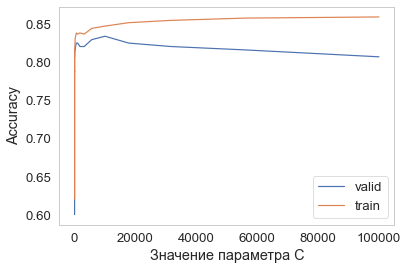

In [54]:
#построим график зависимости значений Accuracy от значения параметра С
plt.plot(c_values, accuracy_on_valid, label="valid")
plt.plot(c_values, accuracy_on_train, label="train")

plt.xlabel('Значение параметра C')
plt.ylabel('Accuracy')

plt.legend()
plt.grid()

plt.show()

**Вывод по <span style="color:red">МЕТОДУ ОПОРНЫХ ВЕКТОРОВ (SVG):</span>**  
Наилучшее значение Accuracy достигается при С от 5.000 до 10.000 и равно 0.84, что уже выше, чем значения Accuracy при использовании логистической регрессии. Улучшая другие параметры модели (kernel, gamma, degree) возможно ещё улушить Accuracy. 

# <span style="color:red">Алгоритм k-ближайщих соседей (K-Nearest Neighbors(KNN))</span>

In [55]:
from sklearn.neighbors import KNeighborsClassifier

**Масштабируем признаки при помощи RobustScaler**

In [56]:
from sklearn.preprocessing import RobustScaler

**Загрузим ранее сохранённые немасштабированные данные**

In [57]:
X_train = pd.read_pickle('X_train.pkl')
y_train = pd.read_pickle('y_train.pkl')

X_valid= pd.read_pickle('X_valid.pkl')
y_valid = pd.read_pickle('y_valid.pkl')

In [58]:
cols_for_scale = ['Age', 'SibSp', 'Parch', 'Fare']
scaler = RobustScaler()
X_train[cols_for_scale] = scaler.fit_transform(X_train[cols_for_scale])

In [59]:
#проверим работу
X_train.describe()

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
count,668.00,668.00,668.00,668.00,668.00,668.00,668.00,668.00,668.00,668.00,668.00
mean,0.34,-0.02,0.55,0.37,0.79,0.18,0.09,0.74,0.23,0.21,0.56
std,0.48,1.00,1.19,0.80,2.29,0.38,0.28,0.44,0.42,0.41,0.50
min,0.00,-2.25,0.00,0.00,-0.64,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,-0.59,0.00,0.00,-0.29,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
75%,1.00,0.41,1.00,0.00,0.71,0.00,0.00,1.00,0.00,0.00,1.00
max,1.00,3.87,8.00,6.00,22.06,1.00,1.00,1.00,1.00,1.00,1.00


In [60]:
X_valid[cols_for_scale] = scaler.transform(X_valid[cols_for_scale])

In [61]:
#проверим работу
X_valid.describe()

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
count,223.00,223.00,223.00,223.00,223.00,223.00,223.00,223.00,223.00,223.00,223.00
mean,0.38,0.05,0.43,0.41,0.79,0.23,0.09,0.69,0.29,0.19,0.52
std,0.49,1.00,0.80,0.84,1.93,0.42,0.28,0.47,0.45,0.40,0.50
min,0.00,-2.22,0.00,0.00,-0.64,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,-0.52,0.00,0.00,-0.29,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.04,0.00,0.00,1.00,0.00,0.00,1.00
75%,1.00,0.48,1.00,1.00,0.75,0.00,0.00,1.00,1.00,0.00,1.00
max,1.00,3.18,4.00,5.00,10.98,1.00,1.00,1.00,1.00,1.00,1.00


**Сохраним параметры модели нормализации**

In [62]:
import joblib
joblib.dump(scaler, 'Robust_scaler.pkl')

['Robust_scaler.pkl']

In [63]:
scaler = joblib.load('min_max_scaler.pkl')

**Данные нормализованы, можно приступать к построению модели KNN**

In [64]:
k_values = np.arange(2, 10)

In [65]:
accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate(k_values):
    clf = KNeighborsClassifier(n_neighbors=value)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_valid)
    y_pred_train = clf.predict(X_train)
        
    acc_valid = accuracy_score(y_valid, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
#выведем каждое второе значение
    if i % 2 == 0:
        print('K = {}'.format(value))
        print('\tacc_valid = {}'.format(acc_valid))
        print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)

K = 2
	acc_valid = 0.7937219730941704
	acc_train = 0.8772455089820359

K = 4
	acc_valid = 0.7892376681614349
	acc_train = 0.8458083832335329

K = 6
	acc_valid = 0.8251121076233184
	acc_train = 0.8353293413173652

K = 8
	acc_valid = 0.7713004484304933
	acc_train = 0.8173652694610778



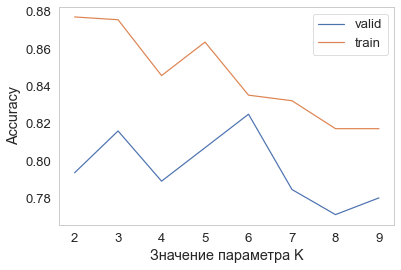

In [66]:
#построим график зависимости значений Accuracy от значения параметра K (количество соседей)
plt.plot(k_values, accuracy_on_valid, label="valid")
plt.plot(k_values, accuracy_on_train, label="train")

plt.xlabel('Значение параметра K')
plt.ylabel('Accuracy')

plt.legend()
plt.grid()

plt.show()

**Наилучшее значение Accuracy достигается при k=6**

In [67]:
clf = KNeighborsClassifier(n_neighbors = 6)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

In [68]:
accuracy_score(y_valid, y_pred)

0.8251121076233184

**Вывод по <span style="color:red">Алгоритму k-ближайщих соседей (KNN):</span>**  
Наилучшее значение Accuracy достигается при K = 6, и равно 0.825, что хуже, чем при использовании метода опорных векторов (SVC) (Accuracy = 0.84), но лучше, чем при использовании линейной модели (Accuracy = 0.8)

# <span style="color:red">Деревья решений (Desicion Trees)</span>

In [69]:
from sklearn.tree import DecisionTreeClassifier

**Загрузим ранее сохранённые немасштабированные данные**

In [70]:
X_train = pd.read_pickle('X_train.pkl')
y_train = pd.read_pickle('y_train.pkl')

X_valid= pd.read_pickle('X_valid.pkl')
y_valid = pd.read_pickle('y_valid.pkl')

**Зададим глубину дерева в виде массива чисел от 2 до 20**

In [71]:
max_depth_values = np.arange(2, 20)
max_depth_values

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])

In [72]:
accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate(max_depth_values):
    clf = DecisionTreeClassifier(max_depth=value)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_valid)
    y_pred_train = clf.predict(X_train)
        
    acc_valid = accuracy_score(y_valid, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
#выведем каждое четвёртое значение
    if i % 4 == 2:
        print('K = {}'.format(value))
        print('\tacc_valid = {}'.format(acc_valid))
        print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)

K = 4
	acc_valid = 0.8071748878923767
	acc_train = 0.842814371257485

K = 8
	acc_valid = 0.7623318385650224
	acc_train = 0.8967065868263473

K = 12
	acc_valid = 0.7399103139013453
	acc_train = 0.9565868263473054

K = 16
	acc_valid = 0.726457399103139
	acc_train = 0.9790419161676647



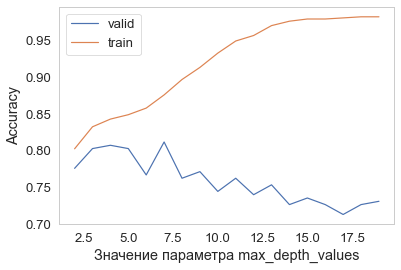

In [73]:
#построим график зависимости значений Accuracy от max_depth_values (максимальная глубина дерева)
plt.rcParams['figure.figsize'] = 6, 4

plt.plot(max_depth_values, accuracy_on_valid, label="valid")
plt.plot(max_depth_values, accuracy_on_train, label="train")

plt.xlabel('Значение параметра max_depth_values')
plt.ylabel('Accuracy')

plt.legend()
plt.grid()

plt.show()

**Наилучшее значение Accuracy достигается при max_depth_values (максимальная глубина дерева) = 7**

In [74]:
clf = DecisionTreeClassifier(max_depth = 7, random_state = 100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

In [75]:
accuracy_score(y_valid, y_pred)

0.8116591928251121

**Вывод по <span style="color:red">алгоритму решающих деревьев (Decision Trees):</span>**  
Наилучшее значение Accuracy достигается при max_depth_values (максимальная глубина дерева) = 7, и равно 0.811, что хуже, чем при использовании метода опорных векторов (SVC) (Accuracy = 0.84) и алгоритма k-ближайщих соседей (KNN) (Accuracy = 0.825), но лучше, чем при использовании линейной модели (Accuracy = 0.8)

# <span style="color:red">Случайный лес (Random Forest)</span>

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

**Зададим параметры случайного леса (число деревьев, число признаков, глубина одного дерева)**

In [77]:
parameters = [{'n_estimators': [150, 200, 15],
              'max_features': np.arange(5,9),
              'max_depth': np.arange(5,10)}]

In [85]:
clf = GridSearchCV(estimator=RandomForestClassifier(),
                   param_grid=parameters,
                   scoring='accuracy',
                   cv=5)

In [81]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             param_grid=[{'max_depth': array([5, 6, 7, 8, 9]),
                          'max_features': array([5, 6, 7, 8]),
                          'n_estimators': [150, 200, 15]}],
             scoring='accuracy')

**Посмотрим на лучшее соотношение**

In [80]:
clf.best_params_

{'max_depth': 5, 'max_features': 5, 'n_estimators': 200}

**Наилучшее значение Accuracy достигается при max_depth (число деревьев) = 5, max_features (число признаков) = 5, n_estimators (глубина одного дерева) = 200**

In [87]:
clf = RandomForestClassifier(max_depth = 5, max_features = 5, n_estimators = 200, random_state = 100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

In [88]:
accuracy_score(y_valid, y_pred)

0.8161434977578476

**Вывод по <span style="color:red">Случайный лес (Random Forest):</span>**  
Наилучшее значение Accuracy достигается при max_depth (число деревьев) = 5, max_features (число признаков) = 5, n_estimators (глубина одного дерева) = 200, и равно 0.816, что хуже, чем при использовании метода опорных векторов (SVC) (Accuracy = 0.84) и алгоритма k-ближайщих соседей (KNN) (Accuracy = 0.825), но лучше, чем при использовании линейной модели (Accuracy = 0.8) и так же, алгоритма решающих деревьев (Decision Forest) (Accuracy = 0.811)

# Подведение итогов и общий вывод:

Самым простым алгоритмом как по времязатратам, так и по вполне сносным результатам оказалась линейная модель (значение Accuracy = 0.8). Линейная модель не требует нормализации признаков и сложной настройки.

Метод опорных векторов (SVC) потребовал нормализации признаков, но даже без нормализации признаков результат показал выше линейной модели (Accuracy = 0.815), а после тюнинга параметра C, результат поднялся до самого высокого из всех мотедов (Accuracy = 0.84).  

Алгоритм k-ближайщих соседей (KNN) так же потребовал нормализации, тюнинга модели и результат получился хуже лучшего варианта (Accuracy = 0.815).

Алгоритм решающих деревьев (Decision Trees) оказался наихудщим, кроме линейной модели (Accuracy = 0.811).  

Случайный лес (Random Forest) на удивление оказался не эффективен и лишь немного улучшил показатели по сравнению с алгоритмом решающих деревьев (Accuracy = 0.816). 